In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import platform
import random
import uuid
import os
import os.path
import skimage
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import networkx
import networkx.algorithms.approximation
import math
import wfdb
import json
import tqdm
import matplotlib.pyplot as plt
import src.data
from scipy.stats import norm
from sak.signal import StandardHeader
from scipy.stats import lognorm, norm, halfnorm

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

# Load files

In [3]:
P = sak.pickleload(os.path.join('.','pickle','Psignal_new.pkl'))
PQ = sak.pickleload(os.path.join('.','pickle','PQsignal_new.pkl'))
QRS = sak.pickleload(os.path.join('.','pickle','QRSsignal_new.pkl'))
ST = sak.pickleload(os.path.join('.','pickle','STsignal_new.pkl'))
T = sak.pickleload(os.path.join('.','pickle','Tsignal_new.pkl'))
TP = sak.pickleload(os.path.join('.','pickle','TPsignal_new.pkl'))

Pamplitudes = sak.pickleload(os.path.join('.','pickle','Pamplitudes_new.pkl'))
PQamplitudes = sak.pickleload(os.path.join('.','pickle','PQamplitudes_new.pkl'))
QRSamplitudes = sak.pickleload(os.path.join('.','pickle','QRSamplitudes_new.pkl'))
STamplitudes = sak.pickleload(os.path.join('.','pickle','STamplitudes_new.pkl'))
Tamplitudes = sak.pickleload(os.path.join('.','pickle','Tamplitudes_new.pkl'))
TPamplitudes = sak.pickleload(os.path.join('.','pickle','TPamplitudes_new.pkl'))

In [4]:
# Smooth all
window = 5
P   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  P[k],window)),metric=sak.signal.abs_max) for k in   P}
PQ  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( PQ[k],window)),metric=sak.signal.abs_max) for k in  PQ}
QRS = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(QRS[k],window)),metric=sak.signal.abs_max) for k in QRS}
ST  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( ST[k],window)),metric=sak.signal.abs_max) for k in  ST}
T   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  T[k],window)),metric=sak.signal.abs_max) for k in   T}
TP  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( TP[k],window)),metric=sak.signal.abs_max) for k in  TP}

In [5]:
# criterion = 'new'
# # PQthres = 1; STthres = 1; Tthres = 1; TPthres = 1;
# # PQthres = 0.3; STthres = 0.4; Tthres = 0.6; TPthres = 0.4;
# plt.figure(); _ = plt.hist(list(Pamplitudes.values()),   bins=1000); plt.title('P amplitudes');   plt.savefig('./figures/Pamplitudes_{}.svg'.format(criterion))
# plt.figure(); _ = plt.hist(list(PQamplitudes.values()),  bins=1000); plt.title('PQ amplitudes');  plt.savefig('./figures/PQamplitudes_{}.svg'.format(criterion))
# plt.figure(); _ = plt.hist(list(QRSamplitudes.values()), bins=1000); plt.title('QRS amplitudes'); plt.savefig('./figures/QRSamplitudes_{}.svg'.format(criterion))
# plt.figure(); _ = plt.hist(list(STamplitudes.values()),  bins=1000); plt.title('ST amplitudes');  plt.savefig('./figures/STamplitudes_{}.svg'.format(criterion))
# plt.figure(); _ = plt.hist(list(Tamplitudes.values()),   bins=1000); plt.title('T amplitudes');   plt.savefig('./figures/Tamplitudes_{}.svg'.format(criterion))
# plt.figure(); _ = plt.hist(list(TPamplitudes.values()),  bins=1000); plt.title('TP amplitudes');  plt.savefig('./figures/TPamplitudes_{}.svg'.format(criterion))

In [5]:
Pdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Pamplitudes.values()))))
PQdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(PQamplitudes.values()))))
QRSdistribution = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.hstack((np.array(list(QRSamplitudes.values())), 2-np.array(list(QRSamplitudes.values()))))))
# QRSdistribution = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(QRSamplitudes.values()))))
STdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(STamplitudes.values()))))
Tdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Tamplitudes.values()))))
TPdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(TPamplitudes.values()))))

# Plot src.data.Dataset

In [101]:
self = src.data.Dataset(P, QRS, T, PQ, ST, TP, 
                        Pdistribution, QRSdistribution, Tdistribution, 
                        PQdistribution, STdistribution, TPdistribution, 
                        200, scaling_metric="sak.signal.abs_max",
#                         proba_AV_block=1,
#                         proba_same_morph=1,
                        proba_TV=1,
#                         proba_AF=0,
#                         proba_tachy=1,
#                         proba_merge_TP=1,
                        return_beats=True, seed=1324)

same_morph:          True	| 	has_arrest: True
has_flatline:        False	| 	has_TV:     True
has_AF:              False	| 	has_tachy:  True
has_AV_block:        False	| 	            


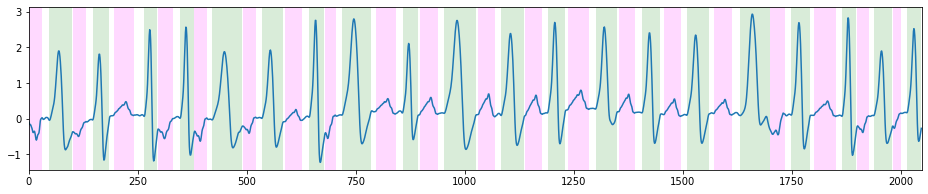

In [241]:
out = self[0]
if len(list(out)) == 2:
    sig,masks_all = out["x"],out["y"]
else:
    sig,masks_all,beats,beat_types,dict_globals = out["x"],out["y"],out["beats"],out["beat_types"],out["dict_globals"],
#     wtlist = [sak.signal.wavelet.transform(beats[i],250.) for i in range(len(beats))]
pon,poff = sak.signal.get_mask_boundary(masks_all[0,:])
qrson,qrsoff = sak.signal.get_mask_boundary(masks_all[1,:])
ton,toff = sak.signal.get_mask_boundary(masks_all[2,:])
sig = sig.squeeze()

print("same_morph:          {}\t| \thas_arrest: {}".format(dict_globals['same_morph'],dict_globals['has_sinus_arrest']))
print("has_flatline:        {}\t| \thas_TV:     {}".format(dict_globals['has_flatline'],dict_globals['has_TV']))
print("has_AF:              {}\t| \thas_tachy:  {}".format(dict_globals['has_AF'],dict_globals['has_tachy']))
print("has_AV_block:        {}\t| \t            {}".format(dict_globals['has_AV_block'],""))
# print(dict_globals['arrest_location'])
# print(dict_globals['IDs']['AV_block'])
# print(dict_globals['IDs']['merge_TP'])
# print(dict_globals['IDs']['AV_block'])

plt.figure(figsize=(16,3))
plt.plot(sig)
# plt.plot(np.zeros_like(sig))
plt.xlim([0,self.N])
[plt.gca().axvspan(pon[i],poff[i], linewidth=0, alpha=0.15, color='red') for i,_ in enumerate(pon)]
[plt.gca().axvspan(qrson[i],qrsoff[i], linewidth=0, alpha=0.15, color='green') for i,_ in enumerate(qrson)]
[plt.gca().axvspan(ton[i],toff[i], linewidth=0, alpha=0.15, color='magenta') for i,_ in enumerate(ton)]
plt.show()

In [142]:
np.clip(np.random.normal()*0.1+0.5,)

0.5306384504287475

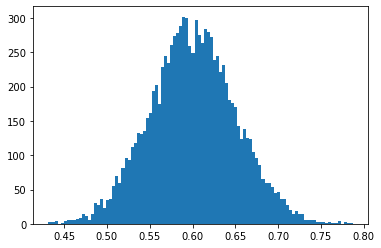

In [221]:
_=plt.hist(np.random.normal(size=10000)*0.05+0.6,bins=100)

In [15]:
import torch

import sak
import sak.torch
import sak.torch.signal
import sak.torch.signal.data
import sak.torch.signal.data.augmentation

In [17]:
self = src.data.Dataset(P, QRS, T, PQ, ST, TP, 
                        Pdistribution, QRSdistribution, Tdistribution, 
                        PQdistribution, STdistribution, TPdistribution, 
                        200, scaling_metric="sak.signal.abs_max")

In [237]:
aug = sak.torch.signal.data.augmentation.RandomSpikes(0.1)

In [18]:
for x,y in torch.utils.data.DataLoader(self,batch_size=16):
    break

In [258]:
%%timeit
noise = aug(x)

3.1 ms ± 79.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [238]:
out = aug(x)

In [257]:
i = 16
plt.figure(figsize=(15,5))
plt.plot(out[i,0])
plt.plot(x[i,0])

IndexError: index 16 is out of bounds for dimension 0 with size 16

<Figure size 1080x360 with 0 Axes>

In [294]:
%%timeit
# After
out = self[0]

9.9 ms ± 506 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [223]:
%%timeit
batch_max = x.max(0).values.max(0).values

60.9 µs ± 374 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


0
0.15672074479540568


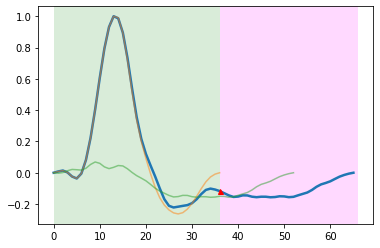

In [2534]:
counter = 0
for _ in range(1000):
    dict_globals = self.generate_globals()
    dict_globals['IDs'] = self.generate_IDs(dict_globals)
    dict_globals['amplitudes'] = self.generate_amplitudes(dict_globals)

    segment1 = self.segment_compose(index, 'QRS', dict_globals, qrs_amplitude)
    segment2 = self.segment_compose(index, 'T', dict_globals, qrs_amplitude)
    
    if (segment1 is None) or (segment2 is None): continue
    
    # %%timeit
#     np.random.seed(seed)
    w1c, w2c = self.segments_convolve(segment1,segment2, reverse='last', sign_relation='equal')
    loc = w1c.size
    break
    
    if loc != segment1.size-1: break
    counter += 1

print(counter)
print(dict_globals['amplitudes']['T'][index])

cncat = np.concatenate((w1c, w2c))
plt.plot(cncat, linewidth=2.5)
plt.plot(loc, cncat[loc], marker='^', markersize=5, color='red')
plt.plot(segment1, alpha = 0.5)
plt.plot(segment2, alpha = 0.5)
plt.gca().axvspan(0,loc, color='green',alpha=0.15, linewidth=0)
plt.gca().axvspan(loc, w1c.size+w2c.size, color='magenta',alpha=0.15, linewidth=0)

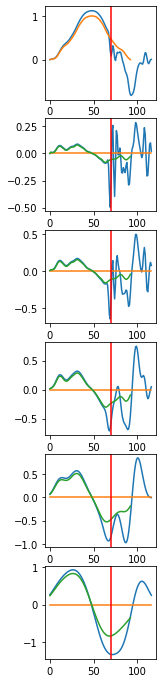

In [2291]:
wt1 = sak.signal.wavelet.transform(segment1,250.)
wt2 = sak.signal.wavelet.transform(segment2,250.)
wtcat = sak.signal.wavelet.transform(cncat,250.)

f,ax = sak.visualization.signal.wavelets(cncat, wtcat, returns=True)
ax[0,0].plot(segment1)
[ax[i+1,0].plot(wt1[:,0,i]) for i in range(5)]
[ax[i,0].axvline(loc, color='red') for i in range(6)]
# sak.visualization.signal.wavelets(cncat, wt2)

In [2274]:
w1 = wt1[:,0,-2]
w2 = wt2[:,0,-2]
np.random.seed(seed)
tmp1,tmp2 = self.segments_convolve(w1,w2)
tmp = np.concatenate((tmp1,tmp2))

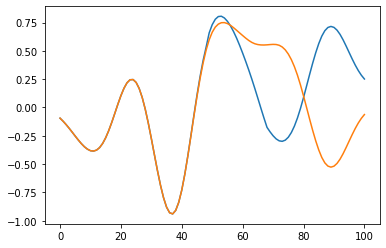

In [2275]:
plt.plot(tmp)
plt.plot(wtcat[:,0,-2])

In [ ]:
crossings

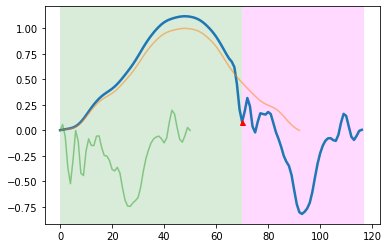

In [2290]:
dict_globals = self.generate_globals()
dict_globals['IDs'] = self.generate_IDs(dict_globals)
dict_globals['amplitudes'] = self.generate_amplitudes(dict_globals)

# T wave in case ectopics
filter = dict_globals['amplitudes']['T'] > 0.75
while np.any(filter):
    # Retrieve generous sample, faster than sampling twice
    new_amplitudes = self.Tdistribution.rvs(self.cycles)
    new_amplitudes = new_amplitudes[new_amplitudes >= self.ectopic_amplitude_threshold]
    # Pad/crop the new dict_globals['amplitudes']
    pad_len = filter.sum()-new_amplitudes.size
    if   pad_len < 0: new_amplitudes = new_amplitudes[:filter.sum()]
    elif pad_len > 0: new_amplitudes = np.pad(new_amplitudes,(0,pad_len))
    # Input into the dict_globals['amplitudes'] vector
    dict_globals['amplitudes']['T'][filter] = new_amplitudes
    filter = dict_globals['amplitudes']['T'] > 0.75

segment1 = self.segment_compose(index, 'QRS', dict_globals, qrs_amplitude)
segment2 = self.segment_compose(index, 'T', dict_globals, qrs_amplitude)
# %%timeit
w1c, w2c = self.segments_convolve(segment1,segment2, reverse='last', sign_relation='equal')
loc = w1c.size

cncat = self.smooth(np.concatenate((w1c, w2c)),self.joint_smoothing_window)
plt.plot(cncat, linewidth=2.5)
plt.plot(loc, cncat[loc], marker='^', markersize=5, color='red')
plt.plot(segment1, alpha = 0.5)
plt.plot(segment2, alpha = 0.5)
plt.gca().axvspan(0,loc, color='green',alpha=0.15, linewidth=0)
plt.gca().axvspan(loc, w1c.size+w2c.size, color='magenta',alpha=0.15, linewidth=0)

In [652]:
dict_globals = self.generate_globals()
dict_globals['IDs'] = self.generate_IDs(dict_globals)
dict_globals['amplitudes'] = self.generate_amplitudes(dict_globals)

In [31]:
# wt = sak.signal.wavelet.transform(sig,250)
# f,ax = sak.visualization.signal.wavelets(sig,wt,figsize=(15,15),returns=True)
# [ax[i,0].set_xlim([0,tmp.N]) for i in range(6)]
# plt.show()

# FIXES ON CURRENT SIGNAL GENERATION CODE

## 3. Convolve shape into another

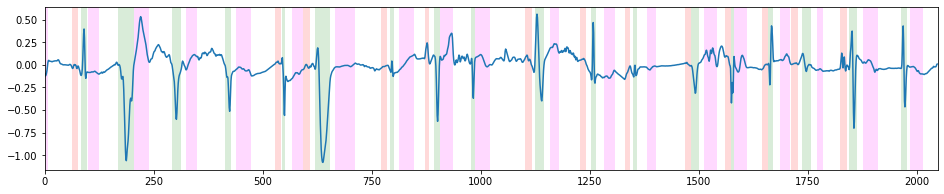

In [1163]:
self.return_beats = True
sig,masks_all,beats,beat_types,dict_globals = self[0]
sig = sig.squeeze()
pon,poff = sak.signal.get_mask_boundary(masks_all[0,:])
qrson,qrsoff = sak.signal.get_mask_boundary(masks_all[1,:])
ton,toff = sak.signal.get_mask_boundary(masks_all[2,:])

plt.figure(figsize=(16,3))
plt.plot(sig)
plt.xlim([0,self.N])
[plt.gca().axvspan(pon[i],poff[i], linewidth=0, alpha=0.15, color='red') for i,_ in enumerate(pon)]
[plt.gca().axvspan(qrson[i],qrsoff[i], linewidth=0, alpha=0.15, color='green') for i,_ in enumerate(qrson)]
[plt.gca().axvspan(ton[i],toff[i], linewidth=0, alpha=0.15, color='magenta') for i,_ in enumerate(ton)]
plt.show()

In [1164]:
index = 0
# dict_globals['IDs']['P'][index] += 1
# dict_globals['amplitudes']['T'][index]
qrs_amplitude = 1

In [1165]:
# %%timeit
dict_globals = self.generate_globals()
dict_globals['IDs'] = self.generate_IDs(dict_globals)
dict_globals['amplitudes'] = self.generate_amplitudes(dict_globals)

t = self.segment_compose(index, 'T', dict_globals, qrs_amplitude)
p = self.segment_compose(index, 'P', dict_globals, qrs_amplitude)

if (p is not None) and (t is not None):
    if (np.max(np.abs(p)) > 0.5*np.max(np.abs(t))):
        # composite = np.zeros((t.size+int(p.size*(np.random.rand()*0.5+0.25))))
        composite = np.pad(t,(0,int(p.size*(np.random.rand()*0.5+0.25))), 'edge')
        reference = np.copy(composite)

        # Reverse p wave if necessary
        sign1 = np.sign(sak.signal.signed_maxima(t))
        sign2 = np.sign(sak.signal.signed_maxima(p))
        if sign1 != sign2: p = p*-1

        # composite[:t.size] += t
        composite[-p.size:] += p

        filt = np.abs(reference[:t.size]-composite[:t.size])/((np.abs(p).max()+np.abs(t).max())/2) > 0.25
        filt[-1] = True
        loc = np.argmax(filt)-3 # Rule of thumb

        plt.plot(t)
        plt.plot(p)
        plt.plot(composite)
        plt.gca().axvspan(0,loc, linewidth=1, alpha=0.15, color='magenta')
        plt.gca().axvspan(loc,composite.size, linewidth=1, alpha=0.15, color='red')
        

In [610]:
%%timeit
# composite = np.zeros((t.size+int(p.size*(np.random.rand()*0.5+0.25))))
composite = np.pad(t,(0,int(p.size*(np.random.rand()*0.5+0.25))), 'edge')
reference = np.copy(composite)

# Reverse p wave if necessary
sign1 = np.sign(sak.signal.signed_maxima(t))
sign2 = np.sign(sak.signal.signed_maxima(p))
if sign1 != sign2: p*-1

# composite[:t.size] += t
composite[-p.size:] += p

filt = np.abs(reference[:t.size]-composite[:t.size])/np.abs(p).max() > 0.25
filt[-1] = True
loc = np.argmax(filt)

62.4 µs ± 848 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
def convolve_shapes(self, segment1: np.ndarray, segment2: np.ndarray, reverse: bool = True):
    # Create a composite shape
    composite = np.pad(segment1,(0,int(segment2.size*(np.random.rand()*0.5+0.25))), 'edge')
    
    # Reference to locate cropping point
    reference = np.copy(composite)

    # Reverse p wave if necessary
    if reverse:
        sign1 = np.sign(sak.signal.signed_maxima(segment1))
        sign2 = np.sign(sak.signal.signed_maxima(segment2))
        if sign1 != sign2: segment2 *= -1
    
    # Add second segment to composite
    composite[-segment2.size:] += segment2
    
    # Compute cropping filter
    filt = np.abs(reference[:segment1.size]-composite[:segment1.size])/np.abs(segment2).max() > self.convolution_ptg
    # In case the above filter is all false
    filt[-1] = True
    # Locate the position where the filter meets the condition
    loc = np.argmax(filt)
    
    return composite[:loc], composite[loc:]

## Efficiency stuff

In [12]:
%%timeit
# Old one, before generating per-cycle
self[0]

14.3 ms ± 610 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
%%timeit
# New, with rvs generation for whole computation
self[0]

9.14 ms ± 332 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [619]:
%%timeit
# Even newer, with ectopics+final smoothing
self[0]

10.2 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%%timeit
# After improving distribution generation process for QRS and ectopics
out = self[0]

8.6 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2398]:
%%timeit
# After adding padding to smoothing fuction (much needed)
self[0]

10.2 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%%timeit
# Adding more amplitude filters
out = self[0]

11.2 ms ± 407 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [403]:
%%timeit
# After filtering all main waves + excluding P waves w.r.t. QRS size and applying sigmoid amplitude modifier
out = self[0]

11.8 ms ± 334 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [98]:
%%timeit
# At some point, latest, 07-Oct-2020
out = self[0]

9.6 ms ± 462 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# OLD AND CREEPY

### Conditional amplitudes

In [4]:
# v02 = [k for k in QRSamplitudes if (QRSamplitudes[k] <= 0.2)]
# v04 = [k for k in QRSamplitudes if (QRSamplitudes[k] > 0.2) and (QRSamplitudes[k] <= 0.4)]
# v06 = [k for k in QRSamplitudes if (QRSamplitudes[k] > 0.4) and (QRSamplitudes[k] <= 0.6)]
# v08 = [k for k in QRSamplitudes if (QRSamplitudes[k] > 0.6) and (QRSamplitudes[k] <= 0.8)]
# v10 = [k for k in QRSamplitudes if (QRSamplitudes[k] > 0.8) and (QRSamplitudes[k] <= 1.0)]

In [7]:
# ampl = STamplitudes
# dist = STdistribution
# ymax = 1.5
# condampl02 = {k: ampl[k] for k in ampl if (k in v02) and (ampl[k] < ymax)}
# condampl04 = {k: ampl[k] for k in ampl if (k in v04) and (ampl[k] < ymax)}
# condampl06 = {k: ampl[k] for k in ampl if (k in v06) and (ampl[k] < ymax)}
# condampl08 = {k: ampl[k] for k in ampl if (k in v08) and (ampl[k] < ymax)}
# condampl10 = {k: ampl[k] for k in ampl if (k in v10) and (ampl[k] < ymax)}

# _=plt.hist(list(condampl04.values()), bins=100)
# rnd = dist.rvs(len(condampl04))
# rnd = rnd*1.75
# rnd = rnd[rnd < ymax]
# _=plt.hist(rnd, bins=100, alpha=0.5)

In [8]:
# for (ampl, dist) in [(Pamplitudes, Pdistribution), (PQamplitudes, PQdistribution), (QRSamplitudes, QRSdistribution),
#                      (STamplitudes, STdistribution), (Tamplitudes, Tdistribution), (TPamplitudes, TPdistribution), ]:
#     ampl2 = np.array(list(ampl.values()))
#     plt.figure()
#     _=plt.hist(ampl2[ampl2<1.5], bins=1000)
#     _=plt.hist(dist.rvs(size=ampl2.size), bins=1000,alpha=0.5)

In [9]:
# N = 100000
# rn = []
# for _ in range(N):
#     rn.append(QRSdistribution.rvs())
#     while (rn[-1] > 1.25) or (rn[-1] < 0.05):
#         rn[-1] = QRSdistribution.rvs()
#     if rn[-1] > 1:
#         rn[-1] = 1
# _=plt.hist(rn,bins=1000)
# plt.ylim([0,np.sqrt(N)])

### Convolving one shape into another

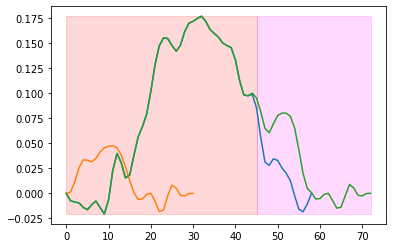

In [620]:
# wave1 = T[list(T)[np.random.randint(len(T))]]*self.distribution_draw('T')
# wave2 = P[list(P)[np.random.randint(len(P))]]*self.distribution_draw('P')
# wave3 = np.pad(wave1,((0,int(wave2.size*(np.random.rand()*0.5+0.25)))),mode='edge')

# max1 = np.sign(sak.signal.signed_maxima(wave1))
# max2 = np.sign(sak.signal.signed_maxima(wave2))

# msk = np.zeros((wave3.size,3),dtype=bool)
# msk[:,2] = 1
# plt.plot(wave1)
# plt.plot(wave2)

# wave4 = np.copy(wave3)
# # wave4[-wave2.size:] += np.convolve(wave4[-wave2.size:],wave2,mode='valid')
# # wave4[-wave2.size:] = np.vstack((wave3[-wave2.size:],wave2)).max(axis=0)
# # loc = np.nonzero((1-(wave3[-wave2.size:]-wave2)/(wave3[-wave2.size:]-wave2).max()) > 0.5)[0][0]
# wave4[-wave2.size:] += wave2*(1-(wave3[-wave2.size:]-wave2)/(wave3[-wave2.size:]-wave2).max())
# loc = np.nonzero(np.abs(wave3-wave4)/wave1.max() > 0.1)[0]
# if loc.size != 0:
#     loc = loc[0]-1
#     msk[loc:,2] = 0
#     msk[loc:,0] = 1
# #     wave4[loc:] /= np.linspace(1,2,wave4.size-loc)**2
# plt.plot(wave4)
# plt.gca().fill_between(np.arange(0,loc+1), wave4.min(), wave4.max(), linewidth=1, alpha=0.15, color='red')
# plt.gca().fill_between(np.arange(loc,wave4.size), wave4.min(), wave4.max(), linewidth=1, alpha=0.15, color='magenta')


# # # Twave2[-TPwave2.size:] += TPwave2
# # conv = np.convolve(wave1[-wave2.size:], wave2, mode='same')
# # conv += wave1[-wave2.size]
# # Twave2[-TPwave2.size:] = conv

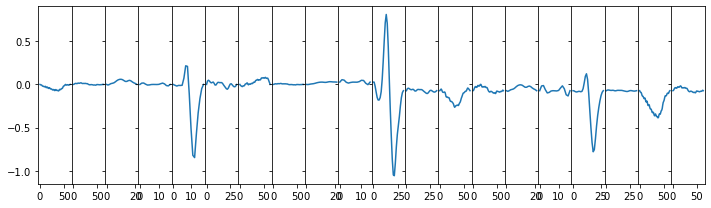

In [16]:
# w = 0
# s = 3
# L = 20
# f,ax = plt.subplots(ncols=L,figsize=(0.5*L,3),sharey=True)
# [ax[i].plot(beats[w+i]) for i in range(L)]
# f.tight_layout()
# f.subplots_adjust(hspace=0.00,wspace=0.00)

In [154]:
# # %%timeit
# # dict_globals['IDs']['TP'][index] = -1
# # dict_globals['IDs']['P'][index] = -1
# # beats.append(...)

# wave1 = T[list(T)[np.random.randint(len(T))]]*self.distribution_draw('T')
# wave2 = P[list(P)[np.random.randint(len(P))]]*self.distribution_draw('P')
# wave3 = np.pad(wave1,((0,int(wave2.size*(np.random.rand()*0.5+0.25)))),mode='edge')

# sign1 = np.sign(sak.signal.signed_maxima(wave1))
# sign2 = np.sign(sak.signal.signed_maxima(wave2))

# if sign1 != sign2: wave2 *= -1
    


# msk = np.zeros((wave3.size,3),dtype=bool)
# msk[:,2] = 1

# wave4 = np.copy(wave3)
# # wave4[-wave2.size:] += np.convolve(wave4[-wave2.size:],wave2,mode='valid')
# # wave4[-wave2.size:] = np.vstack((wave3[-wave2.size:],wave2)).max(axis=0)
# # loc = np.nonzero((1-(wave3[-wave2.size:]-wave2)/(wave3[-wave2.size:]-wave2).max()) > 0.5)[0][0]
# wave4[-wave2.size:] += wave2*(1-(wave3[-wave2.size:]-wave2)/(wave3[-wave2.size:]-wave2).max())
# loc = np.nonzero(np.abs(wave3-wave4)/wave1.max() > 0.1)[0]
# if loc.size != 0:
#     loc = loc[0]-1
#     msk[loc:,2] = 0
#     msk[loc:,0] = 1
# #     wave4[loc:] /= np.linspace(1,2,wave4.size-loc)**2

# plt.plot(wave1)
# plt.plot(wave2)
# plt.plot(wave4)
# plt.gca().fill_between(np.arange(0,loc+1), wave4.min(), wave4.max(), linewidth=1, alpha=0.15, color='red')
# plt.gca().fill_between(np.arange(loc,wave4.size), wave4.min(), wave4.max(), linewidth=1, alpha=0.15, color='magenta')


# # # Twave2[-TPwave2.size:] += TPwave2
# # conv = np.convolve(wave1[-wave2.size:], wave2, mode='same')
# # conv += wave1[-wave2.size]
# # Twave2[-TPwave2.size:] = conv

### Stratify amplitude according to other stuff (minmax ratio, e.g.)

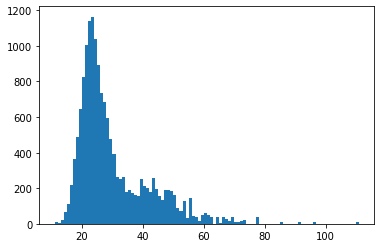

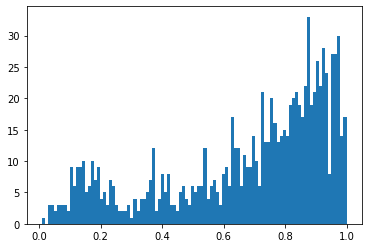

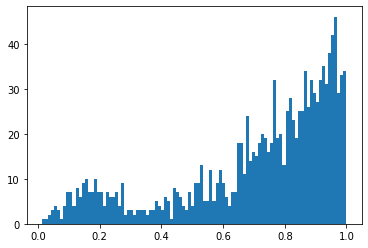

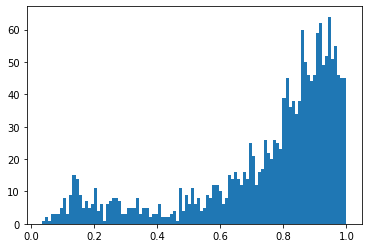

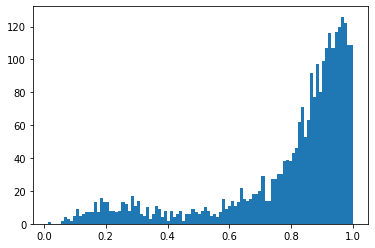

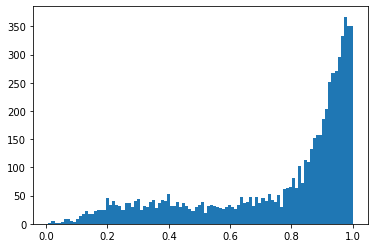

In [47]:
# filt = QRSamplitudes < 1
# aaa = QRSamplitudes[filt]
# bbb = QRSratios[filt]
# ccc = QRSsizes[filt]

# plt.figure(); _ = plt.hist(QRSsizes,bins=100)

# plt.figure(); _ = plt.hist(aaa[bbb<0.2],bins=100)
# plt.figure(); _ = plt.hist(aaa[(bbb>=0.2) & (bbb<0.4)],bins=100)
# plt.figure(); _ = plt.hist(aaa[(bbb>=0.4) & (bbb<0.6)],bins=100)
# plt.figure(); _ = plt.hist(aaa[(bbb>=0.6) & (bbb<0.8)],bins=100)
# plt.figure(); _ = plt.hist(aaa[(bbb>=0.8)],bins=100)


### Ectopics

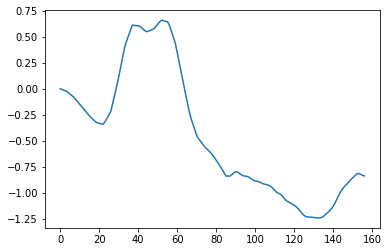

In [435]:
# # %%timeit
# qrs = np.copy(QRS[list(QRS)[np.random.randint(len(QRS))]])
# t   = np.copy(  T[  list(T)[  np.random.randint(len(T))]])

# # plt.figure(); _ = plt.plot(qrs)
# # plt.figure(); _ = plt.plot(t)

# # QRS wave
# crossings = sak.signal.zero_crossings(qrs)[0]
# sign_t = -np.sign(sak.signal.signed_maxima(qrs[crossings[-2]:crossings[-1]]))
# a_max = np.argmax(np.abs(qrs))
# if (crossings[-2] <= a_max) and (crossings[-1] >= a_max):
#     sign_elevation = sign_t
# else:
#     sign_elevation = -sign_t
# qrs_new = self.interpolate_segment(qrs,np.random.randint(30,120))
# qrs_new = self.apply_elevation(qrs_new,1.,sign_elevation)

# # T wave
# # Generate amplitude
# dist = Tdistribution.rvs(200) # Generous sample, faster than sampling twice in case ampl_t < 0.2
# ampl_t = dist[dist > 0.2][0]
# # ampl_t = Tdistribution.rvs()*2
# # if np.random.rand() < 0.5:
# #     crossings_t = sak.signal.zero_crossings(t)[0]
# #     loc_max_t = np.argmax(np.abs(t))
# #     loc_cross_t = np.argmax(crossings_t > loc_max_t)-1
# #     t_new = np.copy(t[crossings_t[loc_cross_t]:])
# # else:
# t_new = np.copy(t)
# # Check if signs differ; if so, reverse T wave
# t_new *= ((-1)**(not np.allclose(sak.signal.signed_maxima(t),sign_t)))
# # Apply amplitude modulation
# t_new *= ampl_t
# t_new  = self.trail_onset(t_new, qrs_new[-1])

# plt.figure(); _ = plt.plot(np.concatenate((qrs_new,t_new)))

In [1013]:
# %%timeit
# crossings = sak.signal.zero_crossings(qrs)[0]
# signed_max_qrs = sak.signal.signed_maxima(qrs)
# signs = np.array([float(sak.signal.signed_maxima(qrs[line[0]:line[1]])) 
#                   for line in np.vstack((crossings[:-1],crossings[1:])).T])
# on = crossings[int(np.argwhere(signs == signed_max_qrs))]
# off = crossings[int(np.argwhere(signs == signed_max_qrs))+1]
# qrs_new = sak.signal.on_off_correction(qrs[on:off])
# qrs_new = self.apply_elevation(qrs_new,'QRS',0.5,sign=-signed_max_qrs)
# qrs_new = sak.data.ball_scaling(qrs_new, metric=sak.signal.abs_max)

# crossings = sak.signal.zero_crossings(t)[0]
# signed_max_t = sak.signal.signed_maxima(t)
# signs = np.array([float(sak.signal.signed_maxima(t[line[0]:line[1]])) 
#                   for line in np.vstack((crossings[:-1],crossings[1:])).T])
# on = crossings[int(np.argwhere(signs == signed_max_t))]
# off = crossings[int(np.argwhere(signs == signed_max_t))+1]
# t_new = sak.signal.on_off_correction(t[on:off])
# t_new = sak.data.ball_scaling(t_new, metric=sak.signal.abs_max)
# t_new = (-1*signed_max_qrs*signed_max_t)*t_new
# t_new = self.trail_onset(t_new,qrs_new[-1])[1:]
# # plt.plot(qrs_new)

525 µs ± 6.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Wavelet stuff

In [ ]:
# w = 0
# s = 3
# L = 20
# f,ax = plt.subplots(ncols=L,figsize=(0.5*L,3),sharey=True)
# [ax[i].plot(beats[w+i]) for i in range(L)]
# [ax[i].plot(wtlist[w+i][:,0,s]) for i in range(L)]
# f.tight_layout()
# f.subplots_adjust(hspace=0.00,wspace=0.00)

In [ ]:
# pad_size = 64
# # i = 1000
# i = 0000
# # i = 14978
# # i = 14979
# s = 4
# sig = QRS[list(QRS)[i]]
# sig2 = np.pad(sig,((pad_size,pad_size),),mode='edge')
# wt = sak.signal.wavelet.transform(sig2,250.).squeeze()
# print(wt.max(0)-wt.min(0))
# print(np.mean((wt.max(0)-wt.min(0))[-2:]))
# wt = wt[pad_size:-pad_size,:]
# plt.figure(figsize=(0.5,3))
# plt.plot(sig)
# plt.plot(wt[:,s])

In [ ]:
# s = 3
# sig2 = np.concatenate(beats)
# wt = sak.signal.wavelet.transform(sig2,250)[:,0,s]
# wtlist = [sak.signal.wavelet.transform(beats[i],250.) for i in range(len(beats))]
# wt2 = np.concatenate([wtlist[w][:,0,s] for w in range(len(wtlist))])

# f,ax = plt.subplots(nrows=4,figsize=(15,9))
# ax[0].plot(sig2)
# ax[1].plot(wt)
# ax[2].plot(wt2)
# ax[3].plot(wt2)
# ax[3].plot(wt)
# [ax[i].set_xlim([0,N]) for i in range(ax.size)]

## Callibrating QRS amplitudes

In [12]:
# QRSamplitudes3 = np.hstack((QRSamplitudes2, 2-QRSamplitudes2))
# QRSamplitudes3dist = scipy.stats.lognorm(*scipy.stats.lognorm.fit(QRSamplitudes3))
# QRSamplitudesExp = scipy.stats.exponnorm(*scipy.stats.exponnorm.fit(QRSamplitudes2))
# QRSamplitudesGamma = scipy.stats.gamma(*scipy.stats.gamma.fit(QRSamplitudes2))
# print((QRSamplitudes2 == 1).sum())
# print((QRSamplitudes2 < 0.1).sum())

In [13]:
# tst3 = QRSamplitudes3dist.rvs(N)
# tst3 = tst3[tst3 <= 1.15]
# tst3 = tst3[tst3 > 0.1]
# tst3 = tst3.clip(max=1)
# (tst3 == 1).sum()

In [14]:
# N = QRSamplitudes2.size
# tst = QRSamplitudes.rvs(N)
# tst = tst[tst <= 1]
# tst = tst[tst > 0.1]
# tst3 = QRSamplitudes3dist.rvs(N)
# tst3 = tst3[tst3 <= 1.005]
# tst3 = tst3[tst3 > 0.1]
# tst3 = tst3.clip(max=1)
# # tst4 = QRSamplitudeslognorm.rvs(N)
# # tst4 = tst4[tst4 <= 1]
# # tst4 = tst4[tst4 > 0.1]
# # _ = plt.hist(tst,bins=1000);
# _ = plt.hist(tst3,bins=1000);
# # _ = plt.hist(tst4,bins=1000);
# # _ = plt.hist(QRSamplitudes2[QRSamplitudes2<1],bins=1000);
# _ = plt.hist(QRSamplitudes2,bins=1000);

## Some old code

In [ ]:
# metric = np.max

# amplitudes = {k.split('###')[0]: [] for k in list(QRS)}
# for k in QRS:
#     g = k.split('###')[0]
#     segment = sak.signal.on_off_correction(QRS[k])
#     amplitudes[g].append(np.max(segment) - np.min(segment))

In [ ]:
# Pamplitudes = []
# for k in P:
#     segment = sak.signal.on_off_correction(P[k])/metric(amplitudes[k.split('###')[0]])
#     Pamplitudes.append(segment.max()-segment.min())
# Pamplitudes = np.array(Pamplitudes)
# PQamplitudes = []
# for k in PQ:
#     segment = sak.signal.on_off_correction(PQ[k])/metric(amplitudes[k.split('###')[0]])
#     PQamplitudes.append(segment.max()-segment.min())
# PQamplitudes = np.array(PQamplitudes)
# QRSamplitudes = []
# for k in QRS:
#     segment = sak.signal.on_off_correction(QRS[k])/metric(amplitudes[k.split('###')[0]])
#     QRSamplitudes.append(segment.max()-segment.min())
# QRSamplitudes = np.array(QRSamplitudes)
# STamplitudes = []
# for k in ST:
#     segment = sak.signal.on_off_correction(ST[k])/metric(amplitudes[k.split('###')[0]])
#     STamplitudes.append(segment.max()-segment.min())
# STamplitudes = np.array(STamplitudes)
# Tamplitudes = []
# for k in T:
#     segment = sak.signal.on_off_correction(T[k])/metric(amplitudes[k.split('###')[0]])
#     Tamplitudes.append(segment.max()-segment.min())
# Tamplitudes = np.array(Tamplitudes)
# TPamplitudes = []
# for k in TP:
#     segment = sak.signal.on_off_correction(TP[k])/metric(amplitudes[k.split('###')[0]])
#     TPamplitudes.append(segment.max()-segment.min())
# TPamplitudes = np.array(TPamplitudes)

# AFib

#### Method 1)

In [ ]:
# #hyperparams
# w = 5
# n = np.random.randint(1,4)

# # Segment retrieval
# segment = P[list(P)[np.random.randint(0,len(P))]]

# # AFib simulation
# on = np.random.choice([0,segment.size,2*segment.size])

# segment  = np.concatenate([-segment,segment]*n)/2
# amplcor  = np.ones_like(segment)

# noise = np.linspace(1,np.random.randn(1),segment.size).squeeze()*0.5+0.5
# segment *= noise
# amplcor *= noise

# # noise = np.sin(np.linspace(0,np.random.randint(5,20),segment.size)+np.random.randn(1))*0.4+0.6
# # segment *= noise
# # amplcor *= noise

# # noise = scipy.signal.chirp(np.linspace(0,np.random.randint(5,20),segment.size),0,200,np.random.randint(5,30))*0.4+0.6
# # segment *= noise
# # amplcor *= noise

# noise = np.convolve(np.random.rand(2*segment.size),np.hamming(w)/(w/2),mode='same')[segment.size//2:-segment.size//2]
# segment *= noise
# amplcor *= noise

# segment  = segment[on:]
# amplcor  = amplcor[on:]
# # segment *= np.max(1/amplcor)
# # segment  = segment/(np.max(segment)-np.min(segment))
# # segment = sak.signal.on_off_correction(segment)
# plt.plot(segment)


In [ ]:
# x = np.linspace(0,1,np.random.randint(10,100))

# fundamentals = [
# #     lambda x,i: x**i,
# #     lambda x,i: (np.sin(x*np.pi/2))**i,
# #     lambda x,i: (-np.cos(x*np.pi/2)+1)**i,
# #     lambda x,i: -np.exp(-(i+2)*x)+1,
#     lambda x,i: np.random.rand(1)/(1 + np.exp(-np.random.randint(10,20)*(x-0.5))),
#     lambda x,i: x,
# ]

# for f in fundamentals:
#     plt.plot(f(x,np.random.randint(1,5)))

In [ ]:
# f = np.random.choice(fundamentals)
# i = np.random.randint(1,10)
# x = np.linspace(0,1,segment.size)

# ix_left = np.random.randint(2,segment.size//4)
# ix_right = np.random.randint(3*segment.size//4,segment.size-1)

# ampl_left = (np.random.rand(1)*0.75+1)
# ampl_right = (np.random.rand(1)*0.75+1)

# x_left = x*ampl_left
# x_right = x*ampl_right-(ampl_right-1)
# x_center = f(np.linspace(0,1,np.random.randint(segment.size//8,ix_right-ix_left)),i)
# # x_center *= np.sin(x_center)
# # x_center
# # x_center = f(np.linspace(0,1,ix_right-ix_left).squeeze(),i)
# x_center = (x_right[ix_right-1]-x_left[ix_left])*x_center/(np.max(x_center)-np.min(x_center))+x_left[ix_left]
# x2 = np.concatenate((x_left[:ix_left],x_center,x_right[ix_right:]))

# print(x.size)
# print(x2.size)

# plt.plot(np.linspace(0,1,x.size),x)
# plt.plot(np.linspace(0,1,x2.size),x2)


In [ ]:
# fundamentals = [
# #     lambda x,i: x**i,
# #     lambda x,i: (np.sin(x*np.pi/2))**i,
# #     lambda x,i: (-np.cos(x*np.pi/2)+1)**i,
# #     lambda x,i: -np.exp(-(i+2)*x)+1,
#     lambda x,i: np.random.rand(1)/(1 + np.exp(-np.random.randint(10,20)*(x-0.5))),
#     lambda x,i: x,
# ]

# #hyperparams
# w = 5
# n = np.random.randint(4,8)

# # Segment retrieval
# segment = P[list(P)[np.random.randint(0,len(P))]]
# # skjggl
# # AFib simulation
# on = np.random.choice([0,segment.size,2*segment.size])
# seglist = []
# x = np.linspace(0,1,segment.size)
# for i in range(n):
#     f = np.random.choice(fundamentals)

#     ix_left = np.random.randint(2,segment.size//4)
#     ix_right = np.random.randint(3*segment.size//4,segment.size-1)

#     ampl_left = (np.random.rand(1)*0.75+1)
#     ampl_right = (np.random.rand(1)*0.75+1)

#     x_left = x*ampl_left
#     x_right = x*ampl_right-(ampl_right-1)
#     x_center = np.linspace(x_left[ix_left],x_right[ix_right-1],np.random.randint(segment.size//4,ix_right-ix_left))
# #     x_center = f(np.linspace(0,1,ix_right-ix_left).squeeze(),np.random.randint(1,10))
# #     x_center = (x_right[ix_right-1]-x_left[ix_left])*x_center/(np.max(x_center)-np.min(x_center))+x_left[ix_left]
    
#     x2 = np.concatenate((x_left[:ix_left],x_center,x_right[ix_right:]))
    
#     print(x2.size)
#     seglist.append(sp.interpolate.interp1d(x,((-1)**i)*segment)(x2)[:-1])
# # plt.plot(segment)
# segment  = np.concatenate(seglist)
# plt.figure()
# plt.plot(segment)


#### Method 2)

In [ ]:
# #hyperparams
# w = 5
# n = np.random.randint(2,8)

# # Segment retrieval
# segment = P[list(P)[np.random.randint(0,len(P))]]

# # AFib simulation
# on = np.random.choice([0,segment.size,2*segment.size])
# seglist = []
# for i in range(n):
#     x = np.linspace(0,1,segment.size)
#     f = np.random.choice(fundamentals)
#     seglist.append(sp.interpolate.interp1d(x,((-1)**i)*segment)(f(x,np.random.randint(1,5))))
# afjsdlkgfj
# plt.plot(segment)
# segment  = np.concatenate(seglist)
# plt.figure()
# plt.plot(segment)


#### Method 3)

In [ ]:
# pAF = P[list(P)[np.random.randint(0,len(P))]]
# pAF = sp.interpolate.interp1d(np.linspace(0,1,pAF.size),pAF)(np.linspace(0,1,pAF.size//2))
# i = np.random.choice([0,1])
# segment  = TP[list(TP)[np.random.randint(0,len(TP))]]
# segment  = sp.interpolate.interp1d(np.linspace(0,1,segment.size),segment)(np.linspace(0,1,segment.size+pAF.size))
# segment  = np.convolve(segment,np.concatenate([((-1)**(i))*pAF,((-1)**(i+1))*pAF]))
# segment /= np.max(segment)-np.min(segment)
# segment *= 2*Pamplitudes.rvs(1)

# plt.plot(pAF)
# plt.figure()
# plt.plot(segment)

#### Compute criteria

In [ ]:
# # Generate wavelets
# Pwavelet = {k: sak.signal.wavelet.transform(Psignal[k],250.).squeeze() for k in tqdm.tqdm(Psignal.keys())}
# PQwavelet = {k: sak.signal.wavelet.transform(PQsignal[k],250.).squeeze() for k in tqdm.tqdm(PQsignal.keys())}
# QRSwavelet = {k: sak.signal.wavelet.transform(QRSsignal[k],250.).squeeze() for k in tqdm.tqdm(QRSsignal.keys())}
# STwavelet = {k: sak.signal.wavelet.transform(STsignal[k],250.).squeeze() for k in tqdm.tqdm(STsignal.keys())}
# Twavelet = {k: sak.signal.wavelet.transform(Tsignal[k],250.).squeeze() for k in tqdm.tqdm(Tsignal.keys())}
# TPwavelet = {k: sak.signal.wavelet.transform(TPsignal[k],250.).squeeze() for k in tqdm.tqdm(TPsignal.keys())}

In [ ]:
# # Generate criteria
# s = 3 # wavelet scale
# eps = np.finfo('float').eps
# Pcriteria = {k: ((np.sign(Pwavelet[k][0,s]),(Pwavelet[k][0,s]-Pwavelet[k][1,s]+eps)/(np.max(Pwavelet[k][:,s])-np.min(Pwavelet[k][:,s]+eps))),
#                  (np.sign(Pwavelet[k][-1,s]),(Pwavelet[k][-1,s]-Pwavelet[k][-2,s]+eps)/(np.max(Pwavelet[k][:,s])-np.min(Pwavelet[k][:,s]+eps)))) for k in Psignal.keys()}
# PQcriteria = {k: ((np.sign(PQwavelet[k][0,s]),(PQwavelet[k][0,s]-PQwavelet[k][1,s]+eps)/(np.max(PQwavelet[k][:,s])-np.min(PQwavelet[k][:,s]+eps))),
#                  (np.sign(PQwavelet[k][-1,s]),(PQwavelet[k][-1,s]-PQwavelet[k][-2,s]+eps)/(np.max(PQwavelet[k][:,s])-np.min(PQwavelet[k][:,s]+eps)))) for k in PQsignal.keys()}
# QRScriteria = {k: ((np.sign(QRSwavelet[k][0,s]),(QRSwavelet[k][0,s]-QRSwavelet[k][1,s]+eps)/(np.max(QRSwavelet[k][:,s])-np.min(QRSwavelet[k][:,s]+eps))),
#                  (np.sign(QRSwavelet[k][-1,s]),(QRSwavelet[k][-1,s]-QRSwavelet[k][-2,s]+eps)/(np.max(QRSwavelet[k][:,s])-np.min(QRSwavelet[k][:,s]+eps)))) for k in QRSsignal.keys()}
# STcriteria = {k: ((np.sign(STwavelet[k][0,s]),(STwavelet[k][0,s]-STwavelet[k][1,s]+eps)/(np.max(STwavelet[k][:,s])-np.min(STwavelet[k][:,s]+eps))),
#                  (np.sign(STwavelet[k][-1,s]),(STwavelet[k][-1,s]-STwavelet[k][-2,s]+eps)/(np.max(STwavelet[k][:,s])-np.min(STwavelet[k][:,s]+eps)))) for k in STsignal.keys()}
# Tcriteria = {k: ((np.sign(Twavelet[k][0,s]),(Twavelet[k][0,s]-Twavelet[k][1,s]+eps)/(np.max(Twavelet[k][:,s])-np.min(Twavelet[k][:,s]+eps))),
#                  (np.sign(Twavelet[k][-1,s]),(Twavelet[k][-1,s]-Twavelet[k][-2,s]+eps)/(np.max(Twavelet[k][:,s])-np.min(Twavelet[k][:,s]+eps)))) for k in Tsignal.keys()}
# TPcriteria = {k: ((np.sign(TPwavelet[k][0,s]),(TPwavelet[k][0,s]-TPwavelet[k][1,s]+eps)/(np.max(TPwavelet[k][:,s])-np.min(TPwavelet[k][:,s]+eps))),
#                  (np.sign(TPwavelet[k][-1,s]),(TPwavelet[k][-1,s]-TPwavelet[k][-2,s]+eps)/(np.max(TPwavelet[k][:,s])-np.min(TPwavelet[k][:,s]+eps)))) for k in TPsignal.keys()}

In [ ]:
# N = 2048
# s = 3

# has_P = np.random.rand(1) > 0.1
# has_PQ = np.random.rand(1) > 0.2
# has_ST = np.random.rand(1) > 0.2
# has_BBB = np.random.rand(1) > 0.9
# counter_BBB = 0
# repetitions_BBB = np.random.randint(2,4)

# beats = []
# ids = []

# # Include first beat
# ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
# beats.append(sak.signal.on_off_correction(TPsignal[list(TPsignal)[ids[-1][1]]]))
# size = beats[0].size
# masks = np.zeros((size,),dtype='int8')
# onset = np.random.randint(0,size)
# while size-onset < N:
#     # P wave (sometimes)
#     if has_BBB:
#         if counter_BBB == 0:
#             id_BBB_P = ('Psignal',np.random.randint(0,len(Psignal)))
#         ids.append(id_BBB_P)
#         p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(p)
#         masks = np.concatenate((masks,1*np.ones((p.size,),dtype='int8')))

#         if has_PQ:
#             # PQ segment
#             ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
#             pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(pq)
#             masks = np.concatenate((masks,np.zeros((pq.size,),dtype='int8')))
#     elif (np.random.rand(1) < 0.75) and (has_P):
#         ids.append(('Psignal',np.random.randint(0,len(Psignal))))
#         p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(p)
#         masks = np.concatenate((masks,1*np.ones((p.size,),dtype='int8')))

#         if has_PQ:
#             # PQ segment
#             ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
#             pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(pq)
#             masks = np.concatenate((masks,np.zeros((pq.size,),dtype='int8')))

#     # QRS wave
#     has_QRS = np.random.rand(1)
#     if has_BBB:
#         if counter_BBB%repetitions_BBB == 0:
#             id_BBB_QRS = ('QRSsignal',np.random.randint(0,len(QRSsignal)))
#             ids.append(id_BBB_QRS)
#             qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(qrs)
#             masks = np.concatenate((masks,2*np.ones((qrs.size,),dtype='int8')))
#         else:
#             pass
#     elif (has_QRS < 0.99):
#         ids.append(('QRSsignal',np.random.randint(0,len(QRSsignal))))
#         qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(qrs)
#         masks = np.concatenate((masks,2*np.ones((qrs.size,),dtype='int8')))
    
#     # ST segment
#     if has_BBB and (counter_BBB%repetitions_BBB != 0):
#         pass
#     elif (np.random.rand(1) < 0.75) and (has_ST):
#         ids.append(('STsignal',np.random.randint(0,len(STsignal))))
#         st = trailonset(STsignal[list(STsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(st)
#         masks = np.concatenate((masks,np.zeros((st.size,),dtype='int8')))

#     # T wave
#     if has_BBB:
#         if counter_BBB%repetitions_BBB == 0:
#             ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
#             t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(t)
#             masks = np.concatenate((masks,3*np.ones((t.size,),dtype='int8')))
#         else:
#             pass
#     elif (has_QRS < 0.99):
#         ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
#         t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(t)
#         masks = np.concatenate((masks,3*np.ones((t.size,),dtype='int8')))

#     # TP segment
#     if has_BBB:
#         if counter_BBB == 0:
#             id_BBB_TP = ('TPsignal',np.random.randint(0,len(TPsignal)))
#         ids.append(id_BBB_TP)
#         tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(tp)
#         masks = np.concatenate((masks,np.zeros((tp.size,),dtype='int8')))
#     else:
#         ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
#         tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(tp)
#         masks = np.concatenate((masks,np.zeros((tp.size,),dtype='int8')))
    
#     # Account for total signal size
#     size = sum([beats[i].size for i in range(len(beats))])
        
#     # Update BBB counter
#     if has_BBB:
#         counter_BBB += 1

# sig = np.concatenate(beats)[onset:onset+2048]
# # sig = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250, 'high'),sig)
# signal = sig# + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

# masks = masks[onset:onset+2048]
# masks_all = np.zeros((N,3),dtype=bool)
# masks_all[:,0] = masks == 1
# masks_all[:,1] = masks == 2
# masks_all[:,2] = masks == 3
# mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

# # f,ax = plt.subplots(nrows=1,figsize=(20,4))
# # ax = np.array(ax)
# # if len(ax.shape) == 0: ax = ax[None]
# # [ax[i].set_xlim([0,N]) for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red') for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green') for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta') for i in range(ax.size)]
# # ax[0].plot(signal)
# # # ax[1].plot(wvlts,color='orange')
# # # ax[2].plot(wvlts_signal,color='orange')

In [ ]:
# N = 2048

# beats = []
# ids = []

# # Include first beat
# ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
# beats.append(sak.signal.on_off_correction(TPsignal[list(TPsignal)[ids[-1][1]]]))
# # beats.append(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
# size = beats[0].size
# masks = np.zeros((size,))
# onset = np.random.randint(0,size)
# while size-onset < N:
#     # P wave (sometimes)
#     if np.random.rand(1) < 0.75:
#         # p = sak.signal.on_off_correction(Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]])
#         ids.append(('Psignal',np.random.randint(0,len(Psignal))))
#         p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])
#         # p = Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]]
#         beats.append(p)
#         masks = np.concatenate((masks,1*np.ones((p.size,))))

#     # PQ segment
#     # pq = sak.signal.on_off_correction(PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]])
#     ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
#     pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])
#     # pq = PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]]
#     beats.append(pq)
#     masks = np.concatenate((masks,np.zeros((pq.size,))))

#     # QRS wave
#     # qrs = sak.signal.on_off_correction(QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]])
#     ids.append(('QRSsignal',np.random.randint(0,len(QRSsignal))))
#     qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])
#     # qrs = QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]]
#     beats.append(qrs)
#     masks = np.concatenate((masks,2*np.ones((qrs.size,))))

#     # ST segment
#     # st = sak.signal.on_off_correction(STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]])
#     ids.append(('STsignal',np.random.randint(0,len(STsignal))))
#     st = trailonset(STsignal[list(STsignal)[ids[-1][1]]],beats[-1][-1])
#     # st = STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]]
#     beats.append(st)
#     masks = np.concatenate((masks,np.zeros((st.size,))))

#     # T wave
#     # t = sak.signal.on_off_correction(Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]])
#     ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
#     t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])
#     # t = Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]]
#     beats.append(t)
#     masks = np.concatenate((masks,3*np.ones((t.size,))))

#     # TP segment
#     # tp = sak.signal.on_off_correction(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
#     ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
#     tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])
#     # tp = TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]]
#     beats.append(tp)
#     masks = np.concatenate((masks,np.zeros((tp.size,))))

#     size = sum([beats[i].size for i in range(len(beats))])

# w = 51
# sig = np.concatenate(beats)[onset:onset+2048]
# sig = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250, 'high'),sig)
# signal = sig# + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

# masks = masks[onset:onset+2048]
# masks_all = np.zeros((N,3),dtype=bool)
# masks_all[:,0] = masks == 1
# masks_all[:,1] = masks == 2
# masks_all[:,2] = masks == 3
# mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

# plt.figure(figsize=(20,5))
# plt.plot(signal)
# plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
# plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
# plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
# plt.show()